In [1]:
import pandas as pd
import os
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder, MinMaxScaler

from imblearn.over_sampling import SMOTE

import seaborn as sns
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from joblib import dump

In [2]:
folder_path_machine = 'MachineLearningCVE'
folder_path_generated = 'TrafficLabelling'


In [3]:
def count_files_in_directory(directory):
    try:
        # List all files and directories in the specified directory
        entries = os.listdir(directory)
        
        # Count only files (not directories)
        file_count = sum(1 for entry in entries if os.path.isfile(os.path.join(directory, entry)))
        
        return file_count
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [4]:
file_count = count_files_in_directory(folder_path_machine)
file_count

8

In [5]:
file_list = [file for file in os.listdir(folder_path_machine) if file.endswith(".csv")]
file_list

['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

In [6]:
data = pd.concat([pd.read_csv(os.path.join(folder_path_machine, file)) for file in file_list], ignore_index=True)

In [7]:
data

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
data = data.drop(columns=['Flow ID', 'Timestamp'], errors='ignore')

In [9]:
# Replace missing/infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()
data


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,53,32215,4,2,112,152,28,28,28.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,53,324,2,2,84,362,42,42,42.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,58030,82,2,1,31,6,31,0,15.5,21.92031,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,53,1048635,6,2,192,256,32,32,32.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [10]:
 # Take 10% of the data
# data = data.sample(frac=0.1, random_state=42)
# data.shape

In [11]:
count = data['Label'].value_counts()
count

Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [12]:
# data['Binary_Label'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [13]:
encoder = LabelEncoder()
data['Encoded_Label'] = encoder.fit_transform(data['Label'])

In [14]:

# scaler = MinMaxScaler()
# numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
# data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [15]:
X = data.drop(['Label', 'Encoded_Label'], axis=1, errors='ignore')  # Features
y = data['Encoded_Label']  # Target variable for binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Encoded_Label, dtype: int64

In [17]:
# Check if y_train is correctly encoded
print("y_train sample:", y_train.head())
print("y_train dtype:", y_train.dtype)

y_train sample: 568457      0
25609       2
334622     10
993727      0
1575255     0
Name: Encoded_Label, dtype: int64
y_train dtype: int64


In [18]:
# Train a Random Forest model
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

In [19]:
# dump(model, "rf_cicids17_model.joblib")

In [20]:
from joblib import load
model = load('rf_cicids17_model.joblib')

In [21]:
y_pred = model.predict(X_test)

In [22]:
# Decode predictions back to original labels
y_pred_labels = encoder.inverse_transform(y_pred)

# Decode true test labels for comparison
y_test_labels = encoder.inverse_transform(y_test)

In [23]:
y_test_labels

array(['BENIGN', 'BENIGN', 'BENIGN', ..., 'BENIGN', 'BENIGN', 'BENIGN'],
      dtype=object)

In [24]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454089
                       Bot       0.91      0.72      0.80       386
                      DDoS       1.00      1.00      1.00     25588
             DoS GoldenEye       1.00      1.00      1.00      2055
                  DoS Hulk       1.00      1.00      1.00     46259
          DoS Slowhttptest       0.99      0.99      0.99      1103
             DoS slowloris       1.00      1.00      1.00      1146
               FTP-Patator       1.00      1.00      1.00      1570
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       1.00      1.00      1.00         5
                  PortScan       0.99      1.00      0.99     31712
               SSH-Patator       1.00      1.00      1.00      1242
  Web Attack � Brute Force       0.74      0.83      0.79       291
Web Attack � Sql Injecti

In [25]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[453784     26      5      1     81      7      0      0      0      0
     184      0      1      0      0]
 [   110    276      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [    14      0  25574      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     5      0      0   2045      3      2      0      0      0      0
       0      0      0      0      0]
 [    55      0      0      4  46196      0      0      0      0      0
       4      0      0      0      0]
 [     6      0      0      0      0   1092      5      0      0      0
       0      0      0      0      0]
 [     3      0      0      0      0      1   1142      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0   1570      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      3      0
       0      0      0      0      0]
 [     0  

New check

In [26]:
y_test

176112      0
264817      0
205084      0
1368918     0
2720654     0
           ..
320048     10
2830090     0
1873349     0
2629528     0
1833536     0
Name: Encoded_Label, Length: 565576, dtype: int64

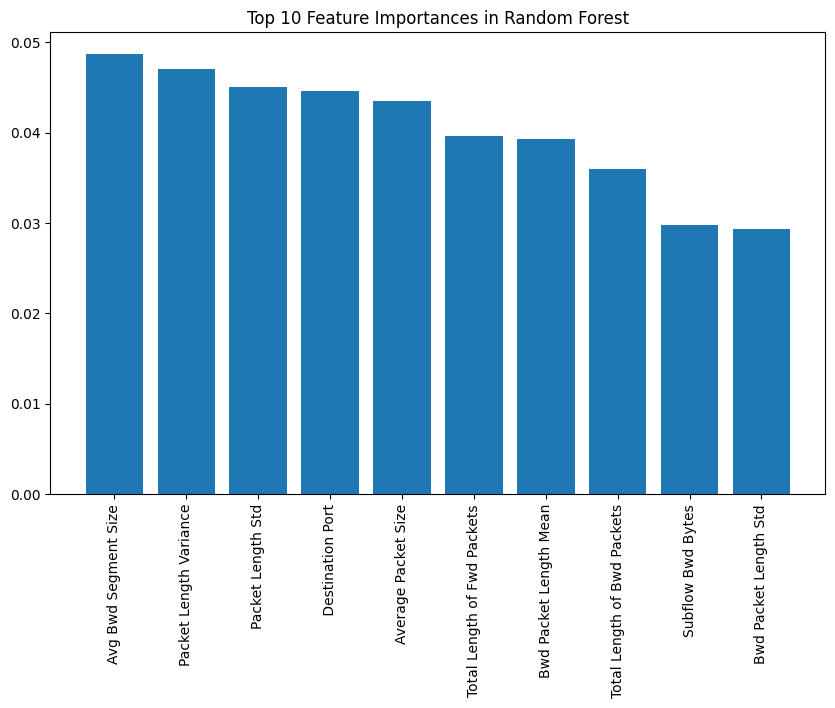

In [27]:
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices[:10])), importances[sorted_indices[:10]], align="center")
plt.xticks(range(len(sorted_indices[:10])), X.columns[sorted_indices[:10]], rotation=90)
plt.title("Top 10 Feature Importances in Random Forest")
plt.show()


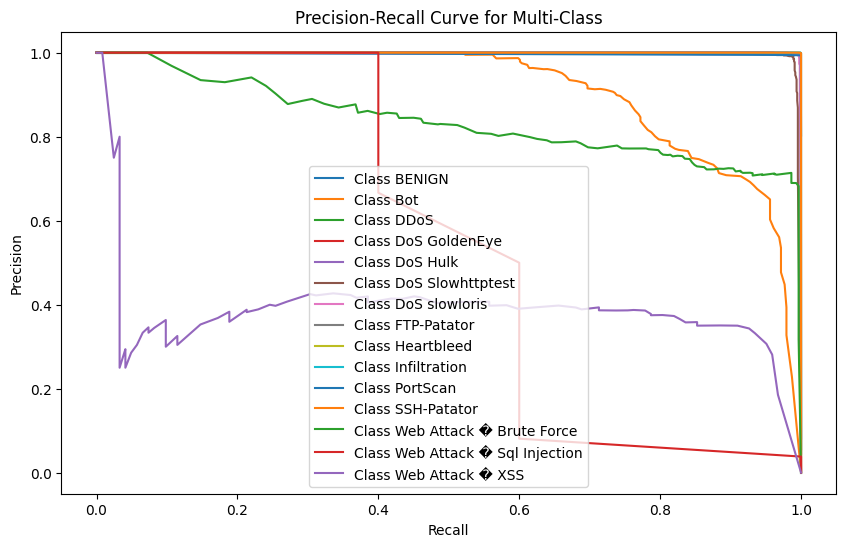

In [28]:
# Binarize the multi-class labels for one-vs-rest precision-recall calculation
y_test_binarized = label_binarize(y_test, classes=range(len(encoder.classes_)))  # Adjust to number of classes

plt.figure(figsize=(10, 6))

# Compute Precision-Recall curve for each class
for i, class_name in enumerate(encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], model.predict_proba(X_test)[:, i])
    plt.plot(recall, precision, label=f"Class {class_name}")

# Add plot details
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Multi-Class")
plt.legend(loc="best")
plt.show()

In [29]:
iso_forest = IsolationForest(contamination=0.1)  # Adjust contamination rate
iso_forest.fit(X_train)
anomalies = iso_forest.predict(X_test)

C:\Users\nazib\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


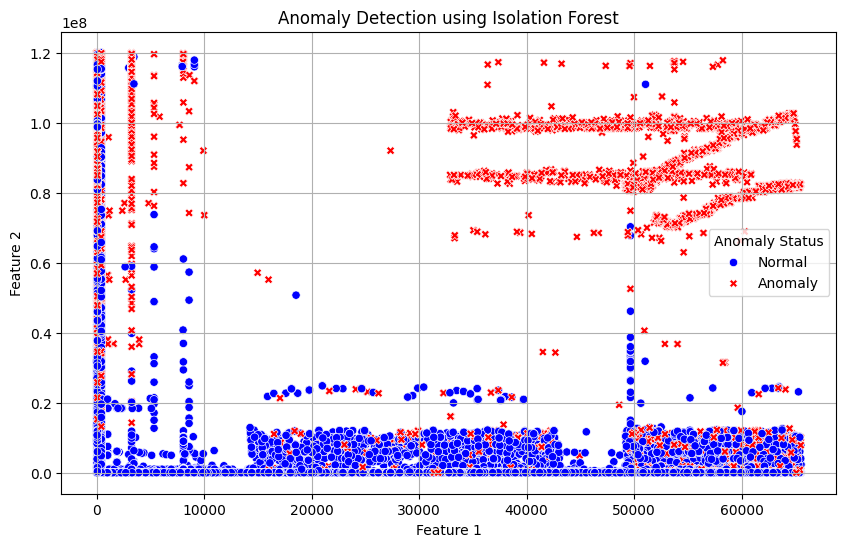

In [30]:
anomalous_data = X_test[anomalies == -1]  # Filter the flagged anomalies
# print(anomalous_data)
# print(anomalies)

# Create a DataFrame for visualization
X_test['anomaly'] = anomalies
X_test['anomaly'] = X_test['anomaly'].map({1: 'Normal', -1: 'Anomaly'})

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_test, x=X_test.columns[0], y=X_test.columns[1], hue='anomaly', style='anomaly', palette={'Normal': 'blue', 'Anomaly': 'red'}, markers={'Normal': 'o', 'Anomaly': 'X'})
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Feature 1')  # Replace with actual feature name
plt.ylabel('Feature 2')  # Replace with actual feature name
plt.legend(title='Anomaly Status')
plt.grid()
plt.show()

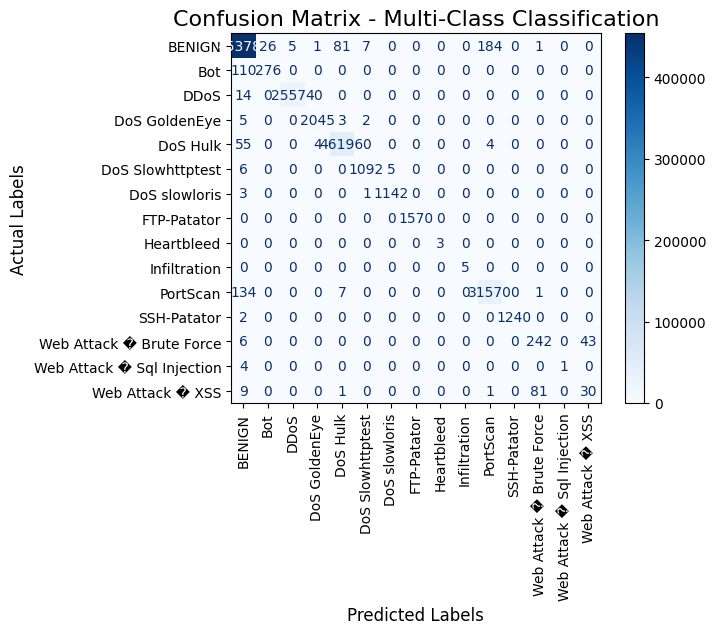

In [31]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay with all class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

# Plot the confusion matrix
disp.plot(cmap="Blues", values_format="d", colorbar=True)


# Add title and labels
plt.title("Confusion Matrix - Multi-Class Classification", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("Actual Labels", fontsize=12)

# Adjust tick marks to display class names
plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=90, fontsize=10)
plt.yticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, fontsize=10)

# Show the plot
plt.show()


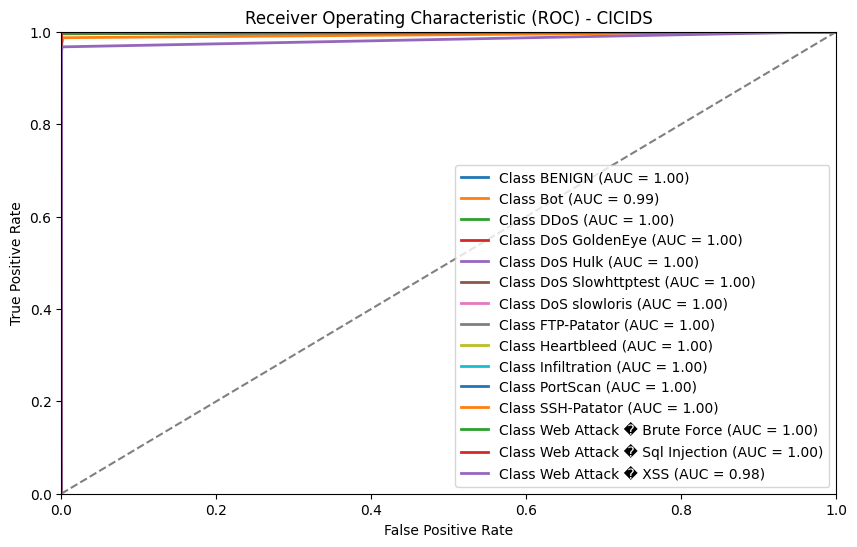

In [32]:
from sklearn.metrics import roc_curve, auc

# Binarize the output labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.arange(len(encoder.classes_)))
n_classes = y_test_binarized.shape[1]

X_test_rf = X_test.drop(columns=['anomaly'], errors='ignore')
y_score = model.predict_proba(X_test_rf)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='Class {0} (AUC = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - CICIDS')
plt.legend(loc="lower right")
plt.show()